# PyGeM

## Tutorial 7: Constrained Free Form Deformation

In this tutorial we show how to utilize a novel technique, Constrained Free Form Deformation, which performs Free Form Deformation while mantaining a multilinear constraint.

We will see the following test cases:
- a custom linear constraint on a set of points in a square
- a barycenter constraint on a sphere
- a volume constraint on a 3D rabbit (meshio is required)

### First Test Case

In [1]:
from pygem.cffd import CFFD

We have 100 some points $x_{i}\in \mathbb{R}^{2}$ in a cube $[0.25,0.75]\times[0.25,0.75]\times[0.25,0.75]$ and we want to deform them using FFD while mantaining their approximate distribution. 

Let's start by generating the points.

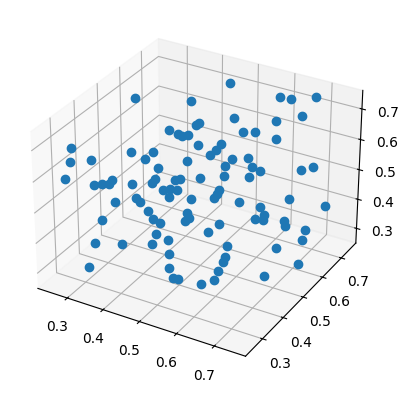

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
x = 0.5 * np.random.rand(100, 3) + 0.25
ax = plt.axes(projection="3d")
ax.plot3D(x[:, 0], x[:, 1], x[:, 2], "o")

Let's start by deforming the points by appling applying FFD.

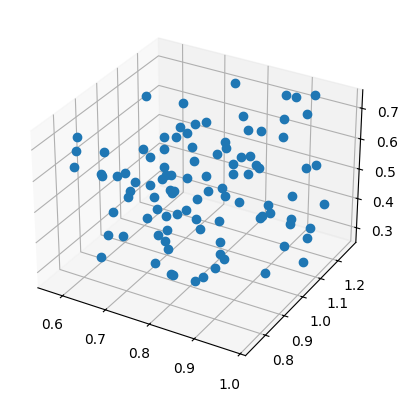

In [3]:
from pygem.ffd import FFD

ffd = FFD([8, 8, 1])
np.random.seed(0)
ffd.array_mu_x = ffd.array_mu_x + 0.5 * np.random.rand(*ffd.array_mu_x.shape)
ffd.array_mu_y = ffd.array_mu_x + 0.5 * np.random.rand(*ffd.array_mu_x.shape)
x_def = ffd(x)
x_def = x_def
ax = plt.axes(projection="3d")
ax.plot3D(x_def[:, 0], x_def[:, 1], x_def[:, 2], "o")

The deformed FFD points have a complete different distribution. We can easily check this by checking the function $\frac{1}{100}\sum_{i=1}^{100} ||x_{i}||_{1}= 1$. As all points are positive, this function is effectively linear.

In [4]:
def custom_linear_constraint(x):
    x = x[:, :-1]  # removing z component
    return np.mean(np.sum(x, axis=1))


print(
    "The custom linear function on the non deformed points is",
    custom_linear_constraint(x),
)
print(
    "The custom linear function on the classic FFD deformed points is",
    custom_linear_constraint(x_def),
)

The custom linear function on the non deformed points is 0.9941248119396184
The custom linear function on the classic FFD deformed points is 1.7889902853626536


We may try to fix this using Constrained Free Form Deformation. Constrained Free Form deformation allows to choose which control points you want to adjust to enforce the constraint. We adjust only the one on x and y, as we want $z$ to remain $0.5$. The indices follow the convention
$[n_{x},n_{y},n_{z},i]$. It also uses a weight matrix $M$ to give control on the movement of the control points.

The custom linear function on the constrained FFD deformed points is 1.2912208217154073


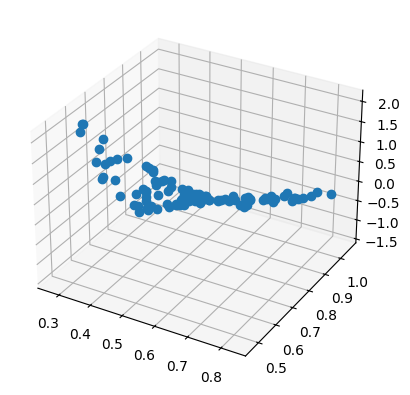

In [5]:
from pygem.cffd import CFFD

ffd = CFFD(np.array([1.0]), custom_linear_constraint, [3, 3, 1])
np.random.seed(0)
ffd.array_mu_x = ffd.array_mu_x + 0.5 * np.random.rand(*ffd.array_mu_x.shape)
ffd.array_mu_y = ffd.array_mu_x + 0.5 * np.random.rand(*ffd.array_mu_x.shape)
ffd.adjust_control_points(x)
x_def = ffd(x)
ax = plt.axes(projection="3d")
ax.plot3D(x_def[:, 0], x_def[:, 1], x_def[:, 2], "o")
print(
    "The custom linear function on the constrained FFD deformed points is",
    custom_linear_constraint(x_def),
)

### Second Test Case


In the Tutorial 1, classic FFD was applied to a sphere. Let's now try to deform that same sphere while mantaining some simmetry around the axis origin. A necessary (but unfortunately not sufficient) condition for simmetry it's to have the barycenter in the axis origin. A Constrained FFD that imposes a barycenter is already implemented.

[-7.85820953e-16 -2.13808138e-16 -1.78190795e-16]


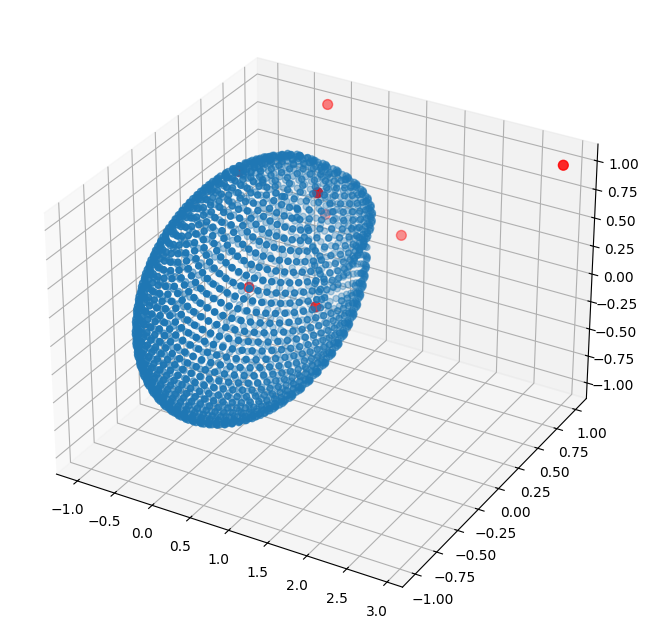

In [6]:
from pygem.bffd import BFFD


def mesh_points(num_pts=2000):
    indices = np.arange(0, num_pts, dtype=float) + 0.5

    phi = np.arccos(1 - 2 * indices / num_pts)
    theta = np.pi * (1 + 5**0.5) * indices

    return np.array(
        [np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)]
    ).T


mesh = mesh_points()
ffd = BFFD(np.array([0.0, 0.0, 0.0]), [2, 2, 2])
ffd.array_mu_x[1, 1, 1] = 2
ffd.array_mu_z[1, 1, 1] = 0
ffd.adjust_control_points(mesh)
mesh_def = ffd(mesh)
print(np.mean(mesh_def, axis=0))
ax = plt.figure(figsize=(8, 8)).add_subplot(111, projection="3d")
ax.scatter(*mesh_def.T)
ax.scatter(*ffd.control_points().T, s=50, c="red")
plt.show()

Notice the difference with respect of the classic FFD deformed one (the same control points deformations were used).

### Third test case


An artisan, Rick, wants to produce some ceramics based on small deformations of the Stanford Bunny. He would like to sell all the ceramics at the same price and would also like that all the ceramics would have the same material costs. This problem could be solved if all deformations would have the same volume. He decides to use a variation of Free Form Deformation that preserves volume.

Firstly, he loads the stl file into python using meshio and he extracts the points and the faces.

In [7]:
import meshio
import numpy as np

mesh = meshio.read("../../tests/test_datasets/Stanford_Bunny.stl")
points = mesh.points
faces = mesh.cells_dict["triangle"]

Furthermore, He reduced the sizes of the sphere to enter the default FFD bounding box. He would like to keep the base of the bunny fixed. He is lucky, because the base of the bunny is parallel to the plane $y=0$, so a simple translation is enough to get the job done.

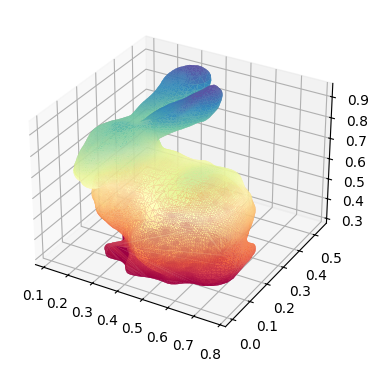

In [8]:
points = points - np.min(points) + 0.1
points = points / np.max(points)
points = 0.95 * points
points[:, 1] = points[:, 1] - np.min(points[:, 1])
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.plot_trisurf(
    points[:, 0], points[:, 1], points[:, 2], triangles=faces, cmap=plt.cm.Spectral
)

Then, he calculates the volume of the initial bunny, and sets up the common ffd parameters. Differently to CFFD and BFFD, VFFD also needs the mesh topology. VFFD also permits to select in which direction there will be the adjustments: Rick choose only the y axis.

In [15]:
from pygem.vffd import VFFD, _volume

initvolume = _volume(points, faces)
vffd = VFFD(faces, np.array(initvolume), [2, 2, 2])

Now he is ready to compute the deformation.

Percentage difference from the original mesh is  70.20924687385559


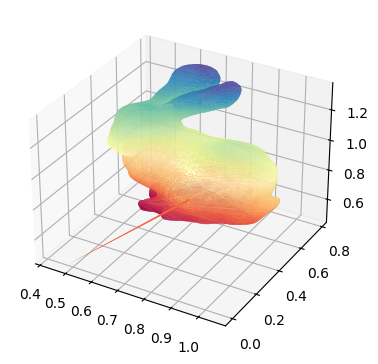

In [16]:
np.random.seed(0)
vffd.array_mu_x = vffd.array_mu_x + 0.5 * np.random.rand(2, 2, 2)
vffd.array_mu_y = vffd.array_mu_y + 0.5 * np.random.rand(2, 2, 2)
vffd.array_mu_z = vffd.array_mu_z + 0.5 * np.random.rand(2, 2, 2)
vffd.adjust_control_points(points)
mesh_def = vffd(points)
mesh_def = mesh_def.reshape(points.shape)
print(
    "Percentage difference from the original mesh is ",
    np.linalg.norm(mesh_def - points) / np.linalg.norm(points) * 100,
)


fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.plot_trisurf(
    mesh_def[:, 0],
    mesh_def[:, 1],
    mesh_def[:, 2],
    triangles=faces,
    cmap=plt.cm.Spectral,
)

Rick is happy!

Jokes aside, a volume constraint has also other applications, for example in a fluidodynamics ship simulation, it is important to preserve the volume of the submerged part of the ship.

Notice that linear constraint can also be combined together, so for example one can impose a barycenter and a volume constraint at the same time. This is left to the reader.